In [1]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

2024-01-09 18:14:18.342838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Original data

In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


### New Felix Data week commencing 18th Dec

In [3]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.training_set_80pct_ODs
# """

# query_job = client.query(query)

# results = query_job.result()

In [4]:
# data = results.to_dataframe()


In [5]:
# data.to_csv('tbd', index=False)


In [6]:
# data_types = {
#     'OriginApt': 'category',
#     'OriginCty': 'category',
#     'OriginCtry': 'category',
#     'DestinationApt': 'category',
#     'DestinationCty': 'category',
#     'DestinationCtry': 'category',
#     'TravelHorizonDays': 'Int32',  # assuming the range fits into int32
#     'TravelDistanceKm': 'Int32',   # likewise, adjust the integer size as needed
#     'SelfTransfer': 'boolean',
#     'Stops': 'Int8',               # if you know the number of stops fits into int8
#     'DurationMin': 'Int32',
#     'dayofweek': 'Int8',
#     'Seg_0_OperatingCarrierIATA': 'category',
#     'Seg_1_OperatingCarrierIATA': 'category',
#     'Seg_2_OperatingCarrierIATA': 'category',
#     'Seg_3_OperatingCarrierIATA': 'category',
#     'Total_Flight_Distance': 'Int32',
#     'Total_Flight_Duration': 'Int32',
#     'passengers': 'Int8',
#     'PricePerPax': 'float32',
#     'ItineraryRedirects': 'Int8',
#     'ODRedirects': 'Int8'
# }

In [7]:
data = pd.read_csv('../raw_data/6_months.csv')

In [8]:
data.columns


Index(['Unnamed: 0', 'OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin', 'dayofweek',
       'Seg_0_OperatingCarrierIATA', 'Seg_1_OperatingCarrierIATA',
       'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA',
       'Total_Flight_Distance', 'Total_Flight_Duration', 'passengers',
       'PricePerPax', 'ItineraryRedirects', 'ODRedirects'],
      dtype='object')

## Running preprocessor

In [9]:
data.isna().sum()

Unnamed: 0                           0
OriginApt                       240517
OriginCty                       240427
OriginCtry                      240427
DestinationApt                  228683
DestinationCty                  228589
DestinationCtry                 229233
TravelHorizonDays                    0
TravelDistanceKm                469016
SelfTransfer                         0
Stops                                0
DurationMin                       4591
dayofweek                            0
Seg_0_OperatingCarrierIATA      634034
Seg_1_OperatingCarrierIATA     9743122
Seg_2_OperatingCarrierIATA    13634592
Seg_3_OperatingCarrierIATA    14062647
Total_Flight_Distance                0
Total_Flight_Duration                0
passengers                           0
PricePerPax                       5902
ItineraryRedirects                   0
ODRedirects                          0
dtype: int64

In [10]:
data.dtypes

Unnamed: 0                      int64
OriginApt                      object
OriginCty                      object
OriginCtry                     object
DestinationApt                 object
DestinationCty                 object
DestinationCtry                object
TravelHorizonDays               int64
TravelDistanceKm              float64
SelfTransfer                     bool
Stops                           int64
DurationMin                   float64
dayofweek                       int64
Seg_0_OperatingCarrierIATA     object
Seg_1_OperatingCarrierIATA     object
Seg_2_OperatingCarrierIATA     object
Seg_3_OperatingCarrierIATA     object
Total_Flight_Distance           int64
Total_Flight_Duration           int64
passengers                      int64
PricePerPax                   float64
ItineraryRedirects              int64
ODRedirects                     int64
dtype: object

In [11]:
# data["OriginCty"] = data["OriginCty"].astype(str)
# data["DestinationCty"] = data["DestinationCty"].astype(str)
# data["'PricePerPax'"] = data["PricePerPax"].astype("Float64")

In [12]:
# smaller_raw_data = data[:5000].copy()

In [13]:
model_columns = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer', "dayofweek",
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax']

In [14]:
model_columns_incltarg = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer', "sin_day", "cos_day",
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax', 'Score_Z_score_0_50']

In [15]:
min_max_col =['TravelHorizonDays']

In [16]:
log_columns = ['extra_travel_distance_ratio', 'PricePerPax', 'total_layover_time_ratio', 'TravelDistanceKm']

In [17]:
# Running Antonis new mega preprocessor

processed_data, prescalars = all_preprocessing(data, model_columns, scale_itin_redirects,
                                               'Score_Z_score_0_50', target_func_param1='ItineraryRedirects',
                                               target_func_param2=0, target_func_param3=50, log_transform_columns=log_columns,
                                               operator_encoding=False, min_max_scaling=min_max_col, od_encoding=False)

/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
processed_data.dtypes

TravelDistanceKm               float64
TravelHorizonDays              float64
SelfTransfer                     int64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
sin_day                        float64
cos_day                        float64
Score_Z_score_0_50             float64
dtype: object

In [19]:
processed_data.head()

,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,sin_day,cos_day,Score_Z_score_0_50
0,7.440734,0.288889,1,0.0,0.693147,5.646182,-0.781831,0.623490,1.251268
1,7.440734,0.288889,1,0.0,0.693147,5.436399,0.974928,-0.222521,1.050187
2,7.440734,0.288889,1,0.0,0.693147,5.309560,0.433884,-0.900969,0.648027
3,7.204893,0.844444,1,0.0,0.693147,5.163900,-0.781831,0.623490,0.340740
4,7.204893,0.844444,1,0.0,0.693147,5.323571,-0.781831,0.623490,0.340740


In [20]:
processed_data.describe()

,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,sin_day,cos_day,Score_Z_score_0_50
count,1.362368e+07,1.409269e+07,1.409269e+07,1.409269e+07,1.362368e+07,1.408677e+07,1.409269e+07,1.409269e+07,1.362361e+07
mean,7.656385e+00,4.199395e-01,9.534667e-01,7.446066e-02,7.154609e-01,4.992440e+00,1.685872e-02,2.477496e-02,8.437104e-01
std,1.019737e+00,2.875081e-01,2.106370e-01,1.291145e-01,7.520184e-02,1.037817e+00,7.132160e-01,7.003035e-01,6.888867e-01
min,4.304065e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.247796e-01,4.510756e-01,-9.749279e-01,-9.009689e-01,0.000000e+00
25%,6.903747e+00,1.666667e-01,1.000000e+00,0.000000e+00,6.931472e-01,4.199830e+00,-7.818315e-01,-9.009689e-01,4.810052e-01
50%,7.536897e+00,3.777778e-01,1.000000e+00,0.000000e+00,6.931472e-01,4.915005e+00,-2.449294e-16,-2.225209e-01,5.823696e-01
75%,8.570165e+00,6.555556e-01,1.000000e+00,1.307702e-01,6.997287e-01,5.838769e+00,7.818315e-01,6.234898e-01,9.346123e-01
max,9.852405e+00,1.000000e+00,1.000000e+00,6.931472e-01,4.071737e+00,2.090079e+01,9.749279e-01,1.000000e+00,5.000000e+01


In [21]:
processed_data["Score_Z_score_0_50"].fillna(0, inplace=True)

In [22]:
processed_data.dropna(inplace=True)

In [23]:
processed_data.isna().sum()

TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
sin_day                        0
cos_day                        0
Score_Z_score_0_50             0
dtype: int64

In [24]:
# processed_data = preprocess(data, raw_od_columns=['OriginCty', 'DestinationCty'], raw_od_ctry=['OriginCtry', 'DestinationCtry'] , as_ratio=True)
# processed_data


In [25]:
# processed_data.to_csv('processed_data.csv', index=False)


In [26]:
# data = pd.read_csv('../raw_data/processed_data.csv')


In [27]:
# data.columns


### Checking the distribution of the target (Score_Z_score_0_50)


In [28]:
# data.value_counts()


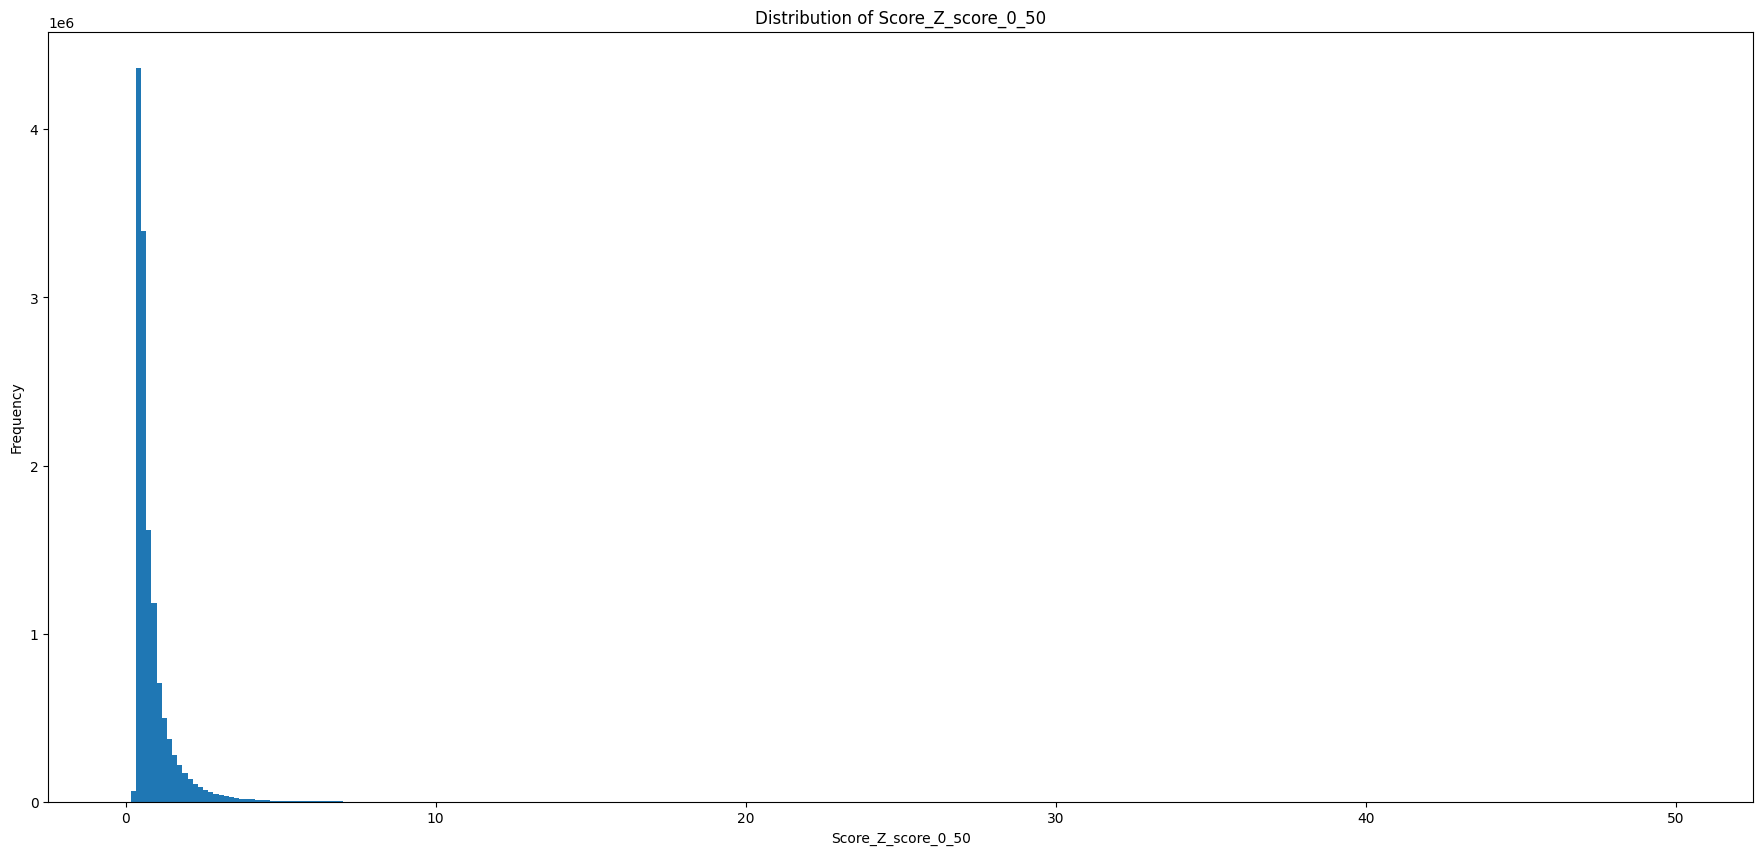

In [29]:
plt.figure(figsize=(22, 10))
plt.hist(processed_data["Score_Z_score_0_50"], bins=300)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50")
plt.show()


In [30]:
# view = data.groupby(["OD", "TravelHorizonDays"])["ODRedirects"].mean()
# view = view.groupby("OD").sum()
# view = view.sort_values(ascending=False)
# view = view.to_frame(name="ODRedirects_per_OD")
# view["cumulative_sum_ODRedirects"] = view.cumsum()
# view["cumulative_perc_ODRedirects"] = 100 * view.cumulative_sum_ODRedirects / view.ODRedirects_per_OD.sum()
# view.reset_index(inplace=True)
# view.ODRedirects_per_OD.sum()
# view.head(20)


In [31]:
# plt.figure(figsize=(22,10))


# # First plot with twinx()
# ax1 = view["cumulative_perc_ODRedirects"].plot(kind="line", color="green", label="cumulative_perc_ODRedirects", grid=True)
# plt.ylabel("cumulative_perc_ODRedirects")

# #Second Plot
# ax2 = ax1.twinx()
# view["cumulative_sum_ODRedirects"].plot(kind="line", color="blue", ax=ax2, label="Cumulative sum ODRedirects")
# plt.ylabel("Cumulative sum of ODRedirects (in millions)")
# plt.title("Cumulative sum of ODRedirects and Cumulative percentage of ODRedirects, by OD")


# # Optional: Add legends
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')


In [32]:
# view.sum()


In [33]:
# view.describe()


## Filter down to the top 10,000 ODs in the view df

### Define the threshold (those ODs responsible for the first 80% of cumulative ODRedirects)

In [34]:
# threshold = 80 # Percentage of ODRedirects below which to keep the ODs
# view = view[view["cumulative_perc_ODRedirects"] <= threshold]
# view.head(20)


In [35]:
# view.describe()


In [36]:
# data.describe()


### Join the view df and the original data df to get just the top performing ODs

In [37]:
# data = pd.merge(data, view, on="OD", how="inner")
# data.describe()


In [38]:
# data["ODRedirects"].describe()


## Continuing the Pre-Processing

In [39]:
model_data = processed_data[model_columns_incltarg].copy()


In [40]:
model_data["SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [41]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,sin_day,cos_day,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
0,7.440734,0.288889,1,-0.781831,0.623490,0.0,0.693147,5.646182,1.251268
1,7.440734,0.288889,1,0.974928,-0.222521,0.0,0.693147,5.436399,1.050187
2,7.440734,0.288889,1,0.433884,-0.900969,0.0,0.693147,5.309560,0.648027
3,7.204893,0.844444,1,-0.781831,0.623490,0.0,0.693147,5.163900,0.340740
4,7.204893,0.844444,1,-0.781831,0.623490,0.0,0.693147,5.323571,0.340740


In [42]:
model_data.dtypes


TravelDistanceKm               float64
TravelHorizonDays              float64
SelfTransfer                     int64
sin_day                        float64
cos_day                        float64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
Score_Z_score_0_50             float64
dtype: object

In [43]:
model_data.isna().sum()


TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
sin_day                        0
cos_day                        0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
Score_Z_score_0_50             0
dtype: int64

In [44]:
# model_data["Score_Z_score_0_50"].fillna(0, inplace=True)


In [45]:
# model_data.isna().sum()


In [46]:
# corr_matrix = model_data.corr()
# corr_matrix


In [47]:
# plt.figure(figsize=(18,8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.show()


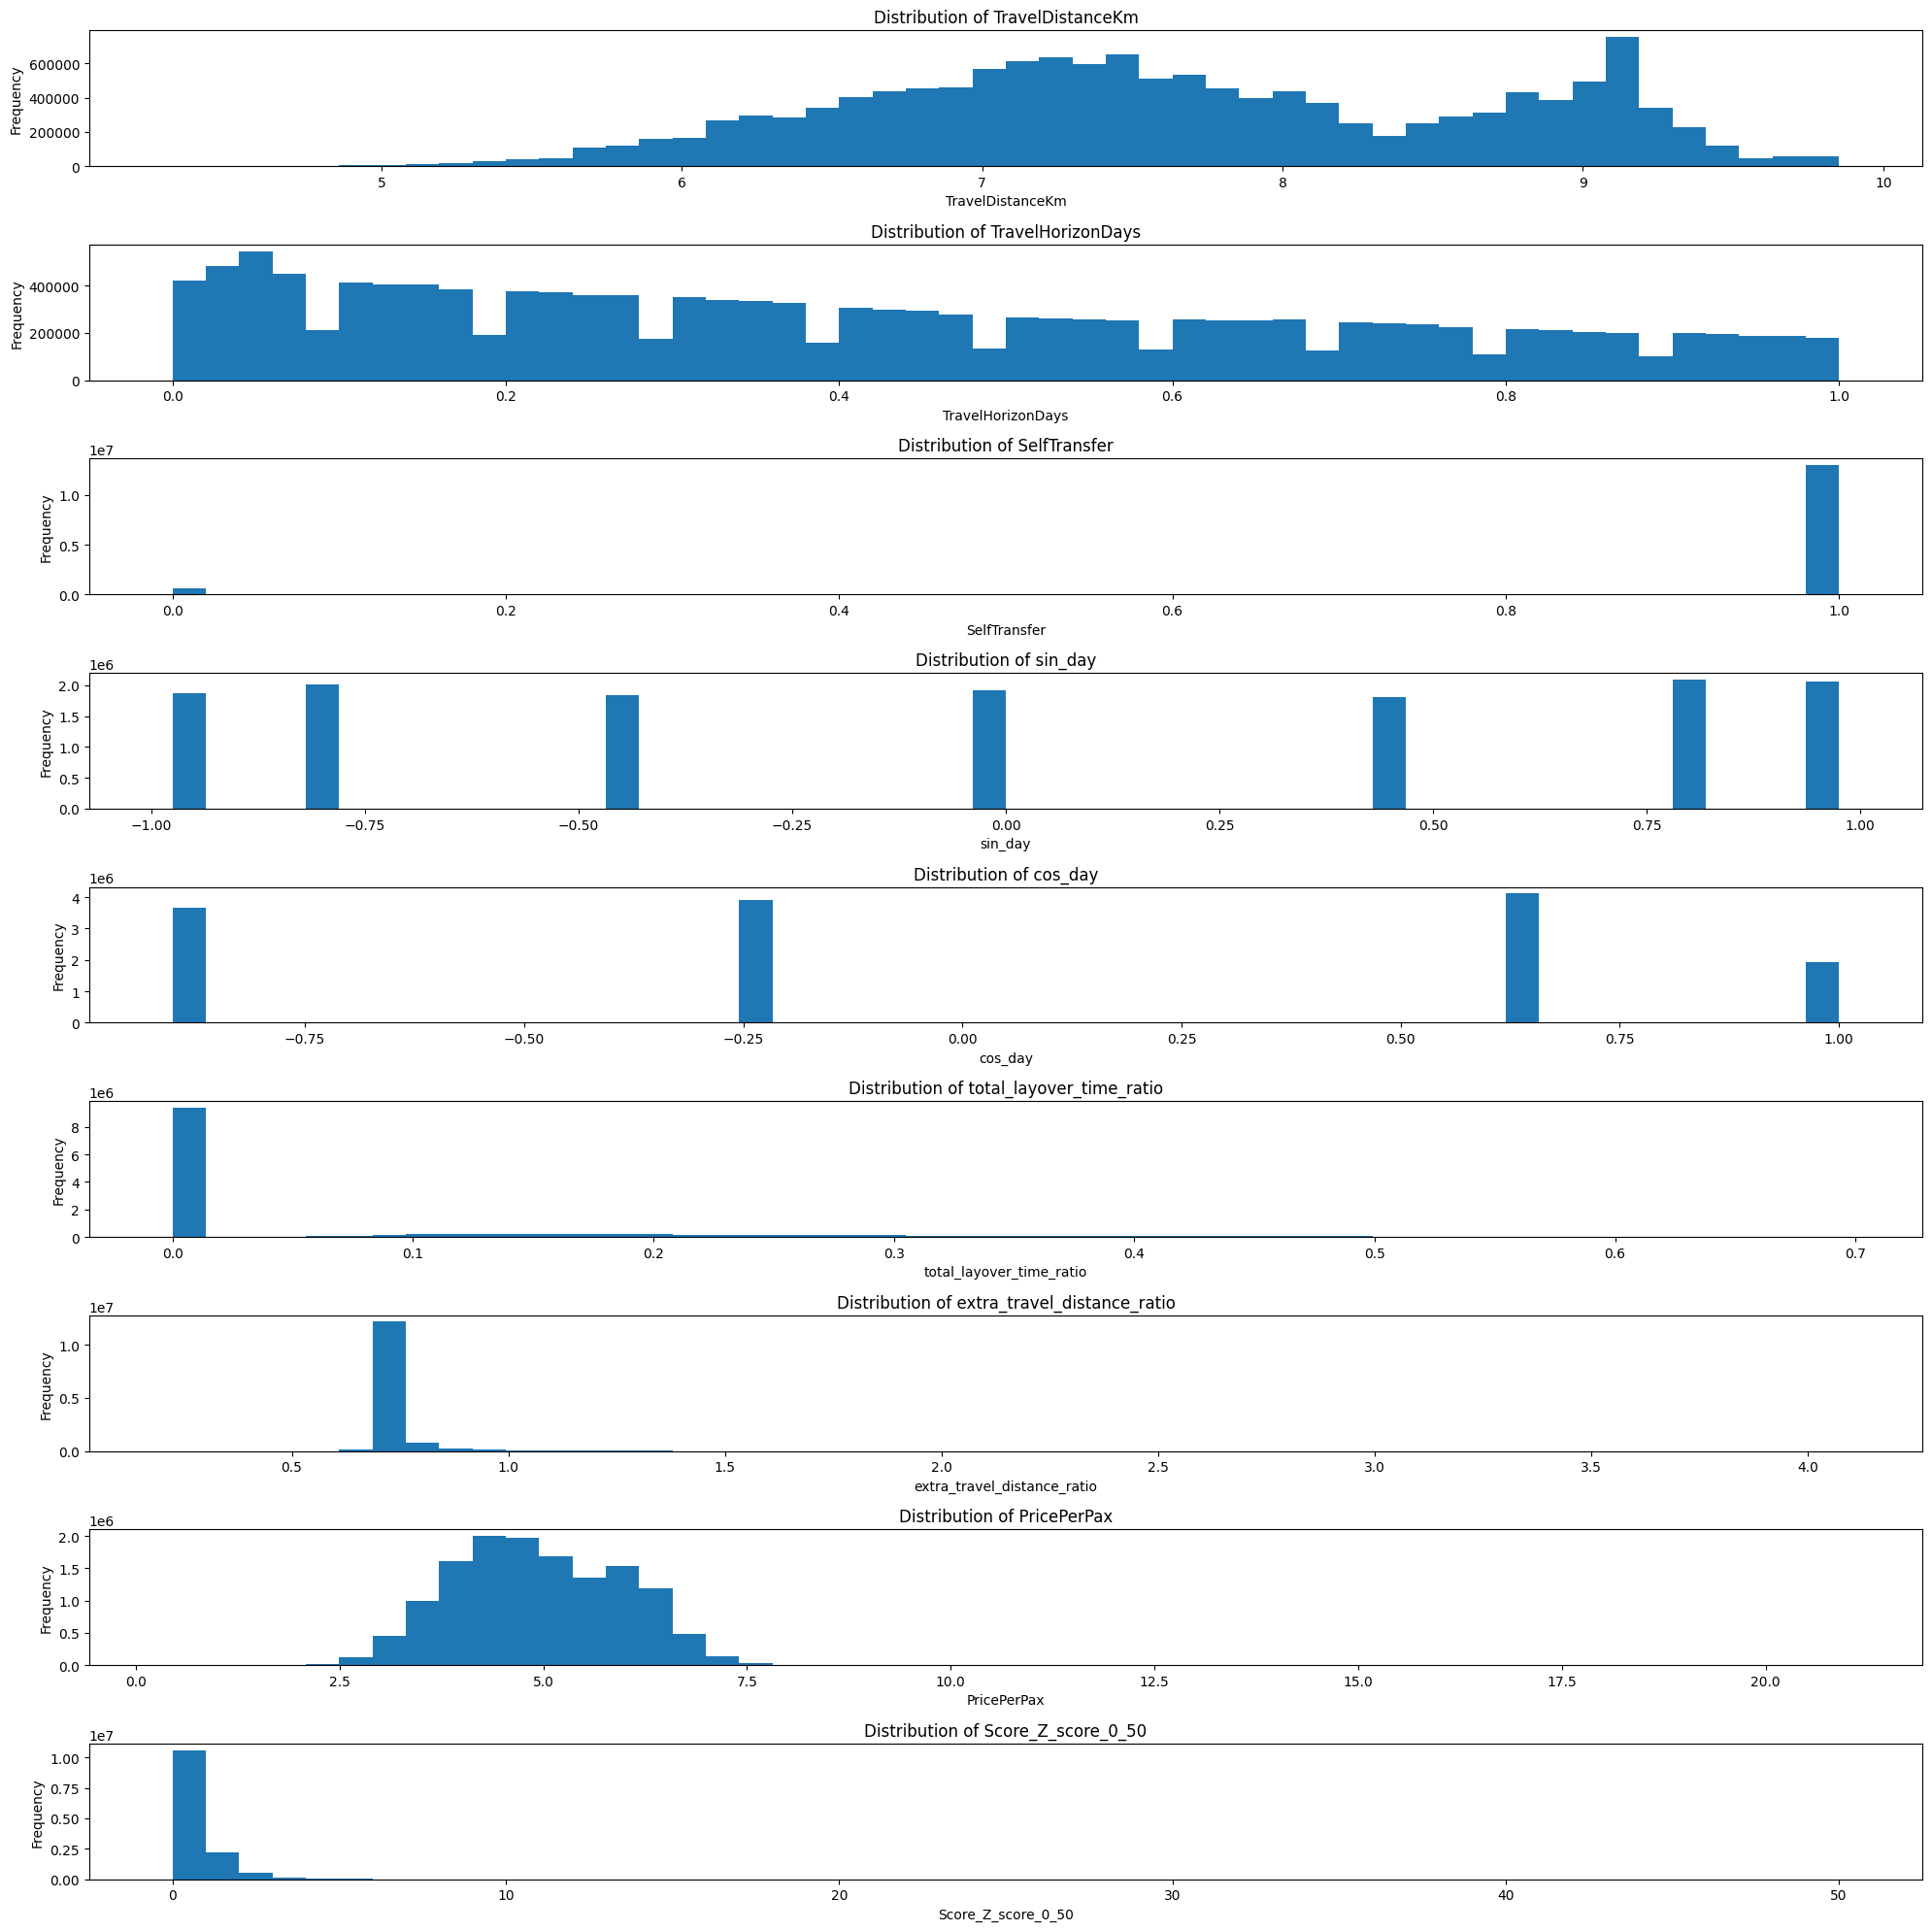

In [48]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist(bins=50)
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Feature Engineering
- Log of extra_travel_distance
- Log of PricePerPax
- Log of total_layover_time_ratio
- Log of TravelDistanceKm

New target reqiures replacment of NaNs by zeros

In [49]:
# model_data.dropna(inplace=True)


In [50]:
# model_data.isna().any().any()


In [51]:
# model_data.isna().sum()


In [52]:
# model_data.head()


In [53]:
# # List of columns to transform
# columns_to_transform = ['extra_travel_distance_ratio', 'PricePerPax', 'total_layover_time_ratio', 'TravelDistanceKm']

# # Apply the transformation in a loop
# for column in columns_to_transform:
#     model_data.loc[:, column] = np.log1p(model_data[column])


In [54]:
# # Set a larger figure size for readability
# plt.figure(figsize=(20, 20))

# # Iterate over the columns and create a subplot for each
# for i, heading in enumerate(model_data.columns):
#     plt.subplot(len(model_data.columns), 1, i+1)
#     model_data[heading].plot.hist(bins=50)
#     plt.title(f'Distribution of Log Scaled {heading}')
#     plt.xlabel(heading)
#     plt.ylabel('Frequency')

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()


### Apply MinMax Scalar

In [55]:
# scaler = MinMaxScaler()


In [56]:
# X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'Score_Z_score_0_50')


In [57]:
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


In [58]:
# model = Sequential()
# model.add(layers.Dense(64, input_dim=8, activation='relu'))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1, activation='linear'))


In [59]:
# model.summary()


In [60]:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=1, mode='min', restore_best_weights=True)


In [61]:
# model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [62]:
# model.fit(X_train, y_train, epochs=15, batch_size=128, verbose=1, callbacks=[early_stopping], validation_split=0.2)


In [63]:
# model.save('model03Jan24.h5')


In [64]:
model = load_model('../models/model03Jan24.h5')


In [65]:
# # Evaluate the model on the test set
# test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# # Print the results
# print(f"Test Loss (MSE): {test_loss}")
# print(f"Test Error (MAE): {test_error}")


In [66]:
# r2_score_DL = r2_score(y_test, model.predict(X_test))
# print(f"The R2 score is: {r2_score_DL}")

In [67]:
# y_pred = model.predict(X_test)


In [68]:
# y_diff = y_pred.flatten() - y_test


In [69]:
# y_diff_abs = y_diff.abs()


In [70]:
# plt.figure(figsize = (18, 10))
# sns.histplot(y_pred.flatten(), bins=50)


In [71]:
dohop_test = pd.read_csv("../raw_data/DohopTest11Dec.csv")
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500


In [72]:
# dohop_test.describe()


In [73]:
dohop_test["SelfTransfer"] = 1
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1


In [74]:
dohop_test['total_layover_time_ratio'] = dohop_test["connection_time"] / (dohop_test["connection_time"] + dohop_test["total_flight_time"])
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer,total_layover_time_ratio
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1,0.512195
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1,0.247059
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1,0.589744
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1,0.352941
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1,0.346535


In [75]:
dohop_test["extra_travel_distance_ratio"] = dohop_test["total_distance"] / dohop_test["direct_distance"]
dohop_test.head()


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,1,0.512195,1.854818
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1,0.247059,1.016140
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,1,0.589744,1.197750
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,1,0.352941,1.106451
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,1,0.346535,1.101503


In [76]:
dohop_test.rename(columns={"total_distance": "TravelDistanceKm", "days_to_travel": "TravelHorizonDays", "itinerary_fare": "PricePerPax", },inplace=True)
dohop_test.columns


Index(['flights', 'origin_iata', 'destination_iata', 'connection_airport',
       'total_flight_time', 'connection_time', 'TravelHorizonDays',
       'dayofweek', 'pax', 'bookings', 'booked_fare', 'TravelDistanceKm',
       'direct_distance', 'PricePerPax', 'SelfTransfer',
       'total_layover_time_ratio', 'extra_travel_distance_ratio'],
      dtype='object')

In [77]:
model_columns


['TravelDistanceKm',
 'TravelHorizonDays',
 'SelfTransfer',
 'dayofweek',
 'total_layover_time_ratio',
 'extra_travel_distance_ratio',
 'PricePerPax']

In [78]:
dohop_columns = ['TravelDistanceKm',
 'TravelHorizonDays',
 'SelfTransfer',
 'dayofweek',
 'total_layover_time_ratio',
 'extra_travel_distance_ratio',
 'PricePerPax', "bookings"]


In [79]:
dohop_test = dohop_test[dohop_columns].copy()


In [80]:
dohop_test["bookings"].fillna(0, inplace=True)


In [81]:
dohop_test.isna().sum()


TravelDistanceKm                  8861
TravelHorizonDays                    0
SelfTransfer                         0
dayofweek                            0
total_layover_time_ratio             0
extra_travel_distance_ratio       8861
PricePerPax                    1152081
bookings                             0
dtype: int64

In [82]:
dohop_test.dropna(inplace=True)
dohop_test.isna().sum()


TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
dayofweek                      0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
bookings                       0
dtype: int64

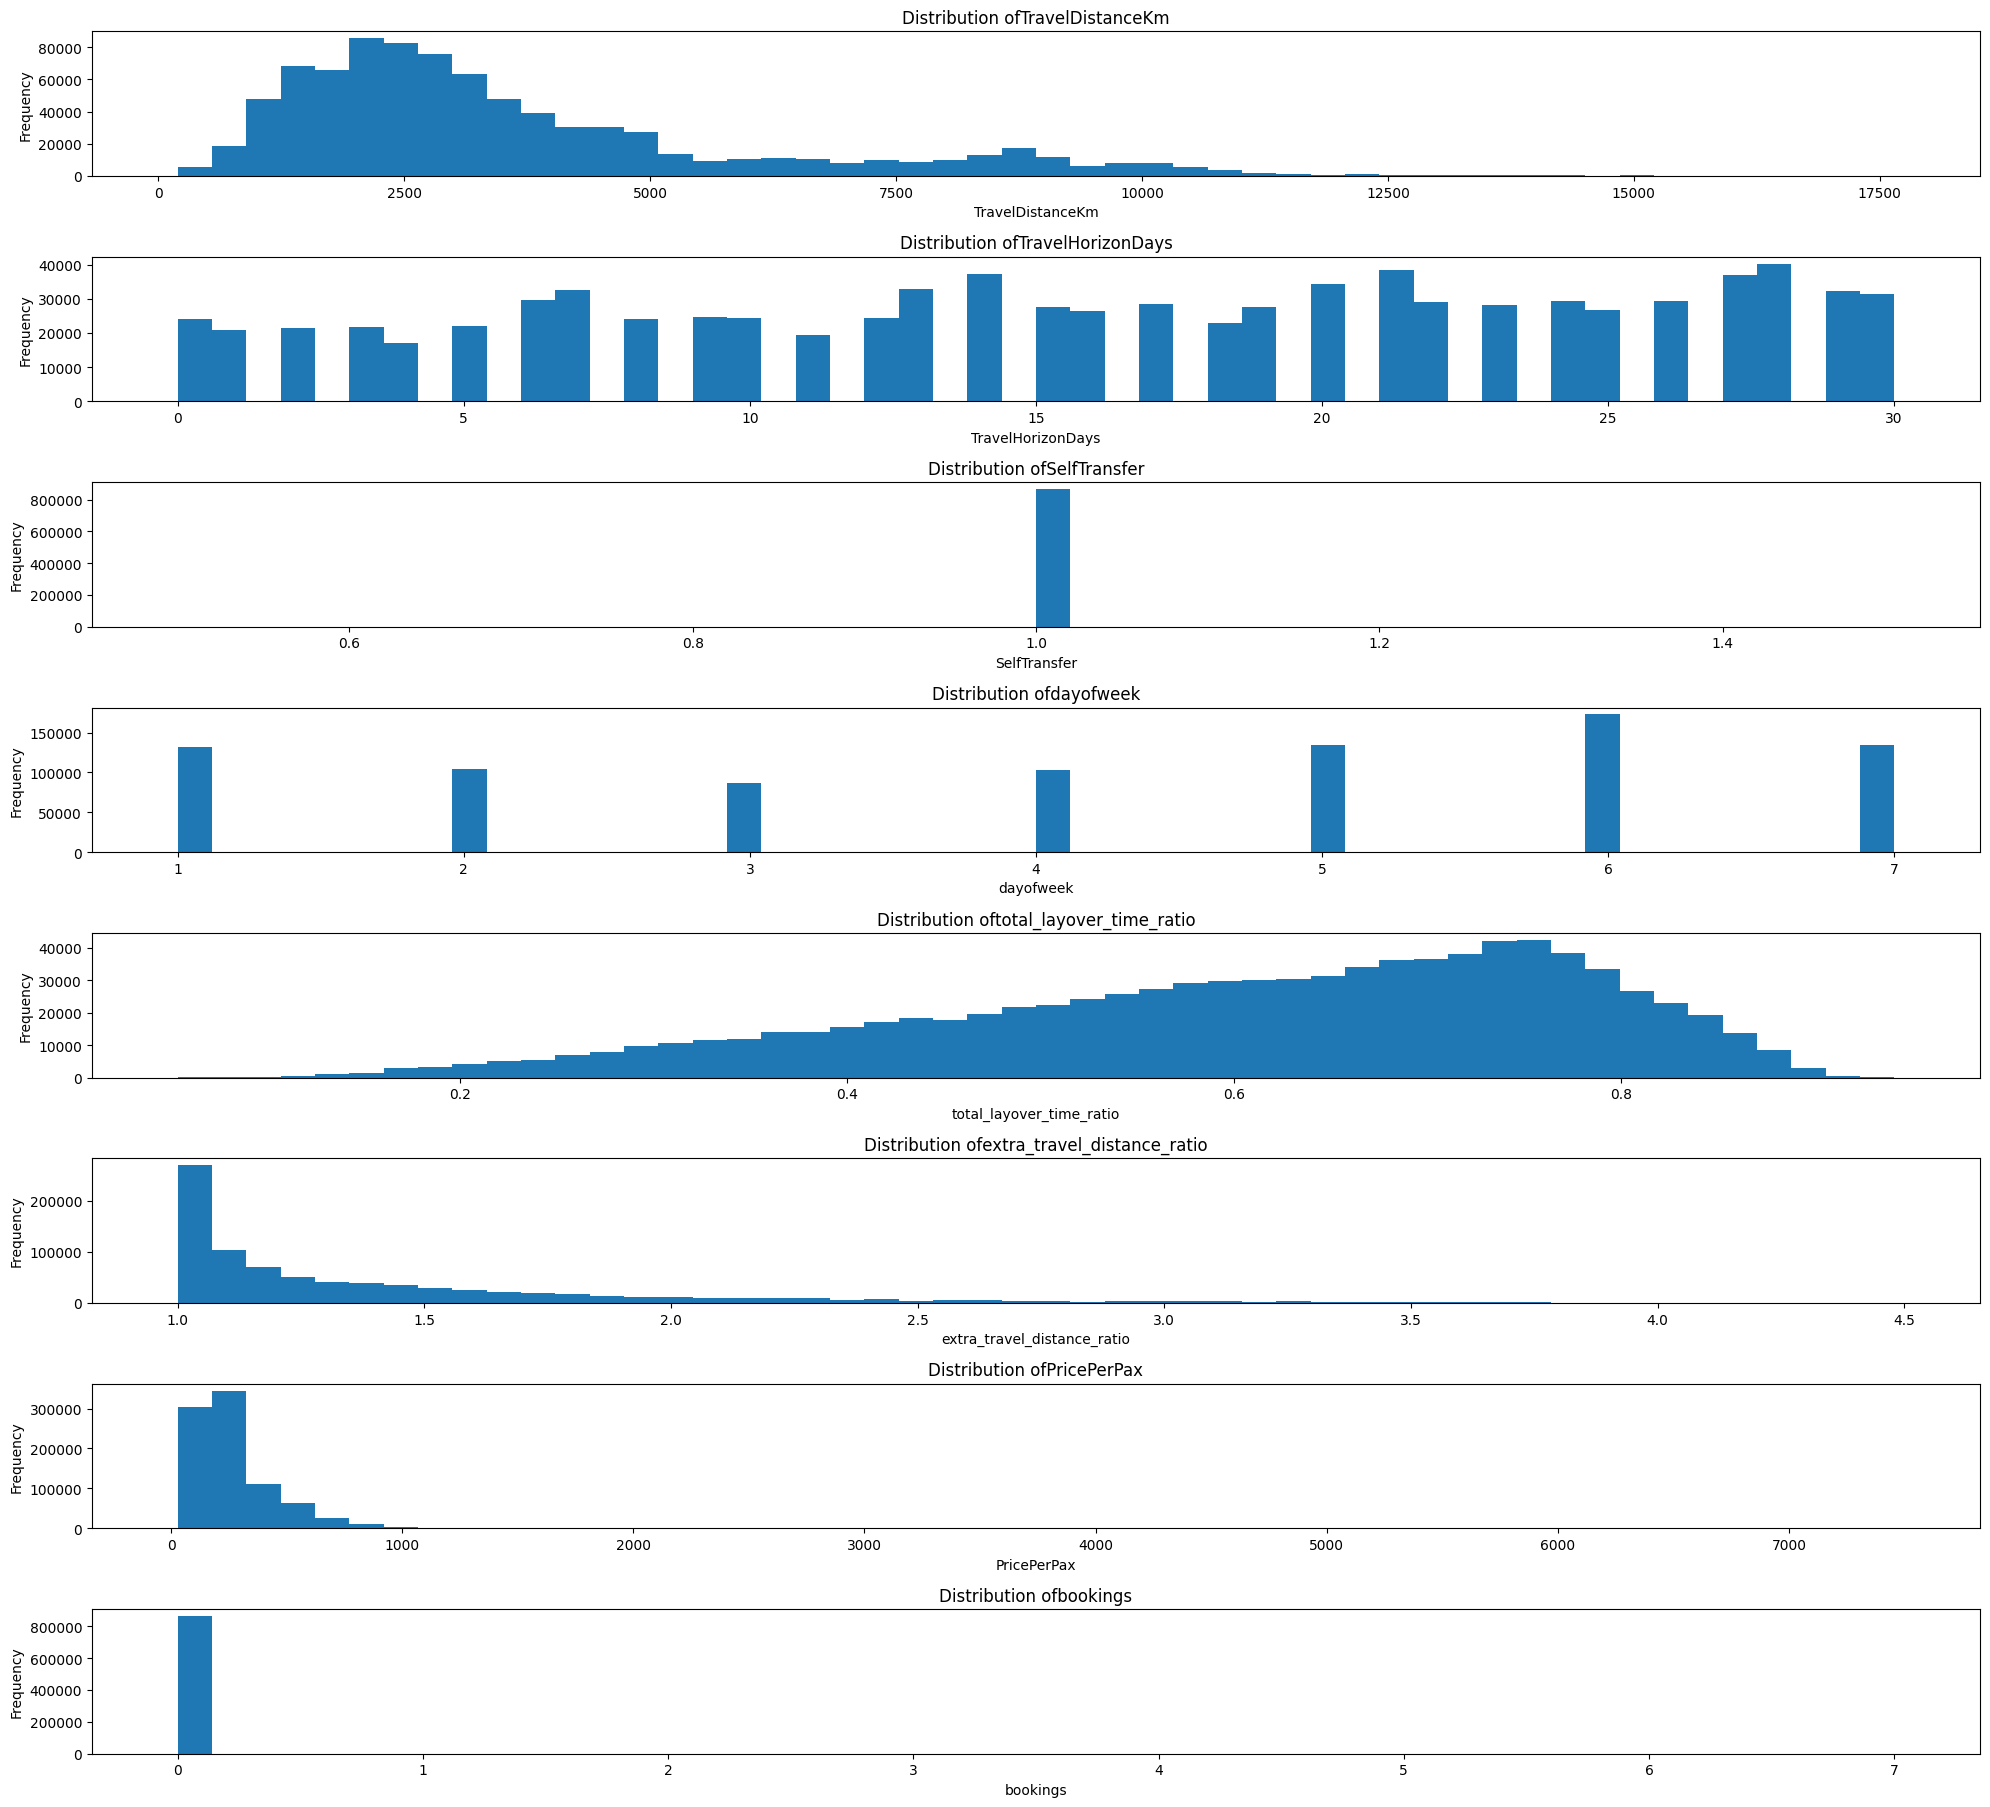

In [83]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(dohop_test.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of{heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [84]:
# Cyclical encoding
dohop_test['sin_day'] = np.sin(2 * np.pi * dohop_test['dayofweek'] / 7)
dohop_test['cos_day'] = np.cos(2 * np.pi * dohop_test['dayofweek'] / 7)
dohop_test.drop(columns=['dayofweek'], inplace=True)

In [85]:

# Apply the transformation in a loop
for column in log_columns:
    dohop_test.loc[:, column] = np.log1p(dohop_test[column])


In [86]:
dohop_scaler = prescalars.minmax_scaler["TravelHorizonDays"]
dohop_scaler

MinMaxScaler()

In [87]:
dohop_test["TravelHorizonDays"] = dohop_scaler.transform(dohop_test["TravelHorizonDays"].values.reshape(-1, 1))

/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [88]:
model_data.dtypes

TravelDistanceKm               float64
TravelHorizonDays              float64
SelfTransfer                     int64
sin_day                        float64
cos_day                        float64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
Score_Z_score_0_50             float64
dtype: object

In [89]:
dohop_test.dtypes

TravelDistanceKm               float64
TravelHorizonDays              float64
SelfTransfer                     int64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
bookings                       float64
sin_day                        float64
cos_day                        float64
dtype: object

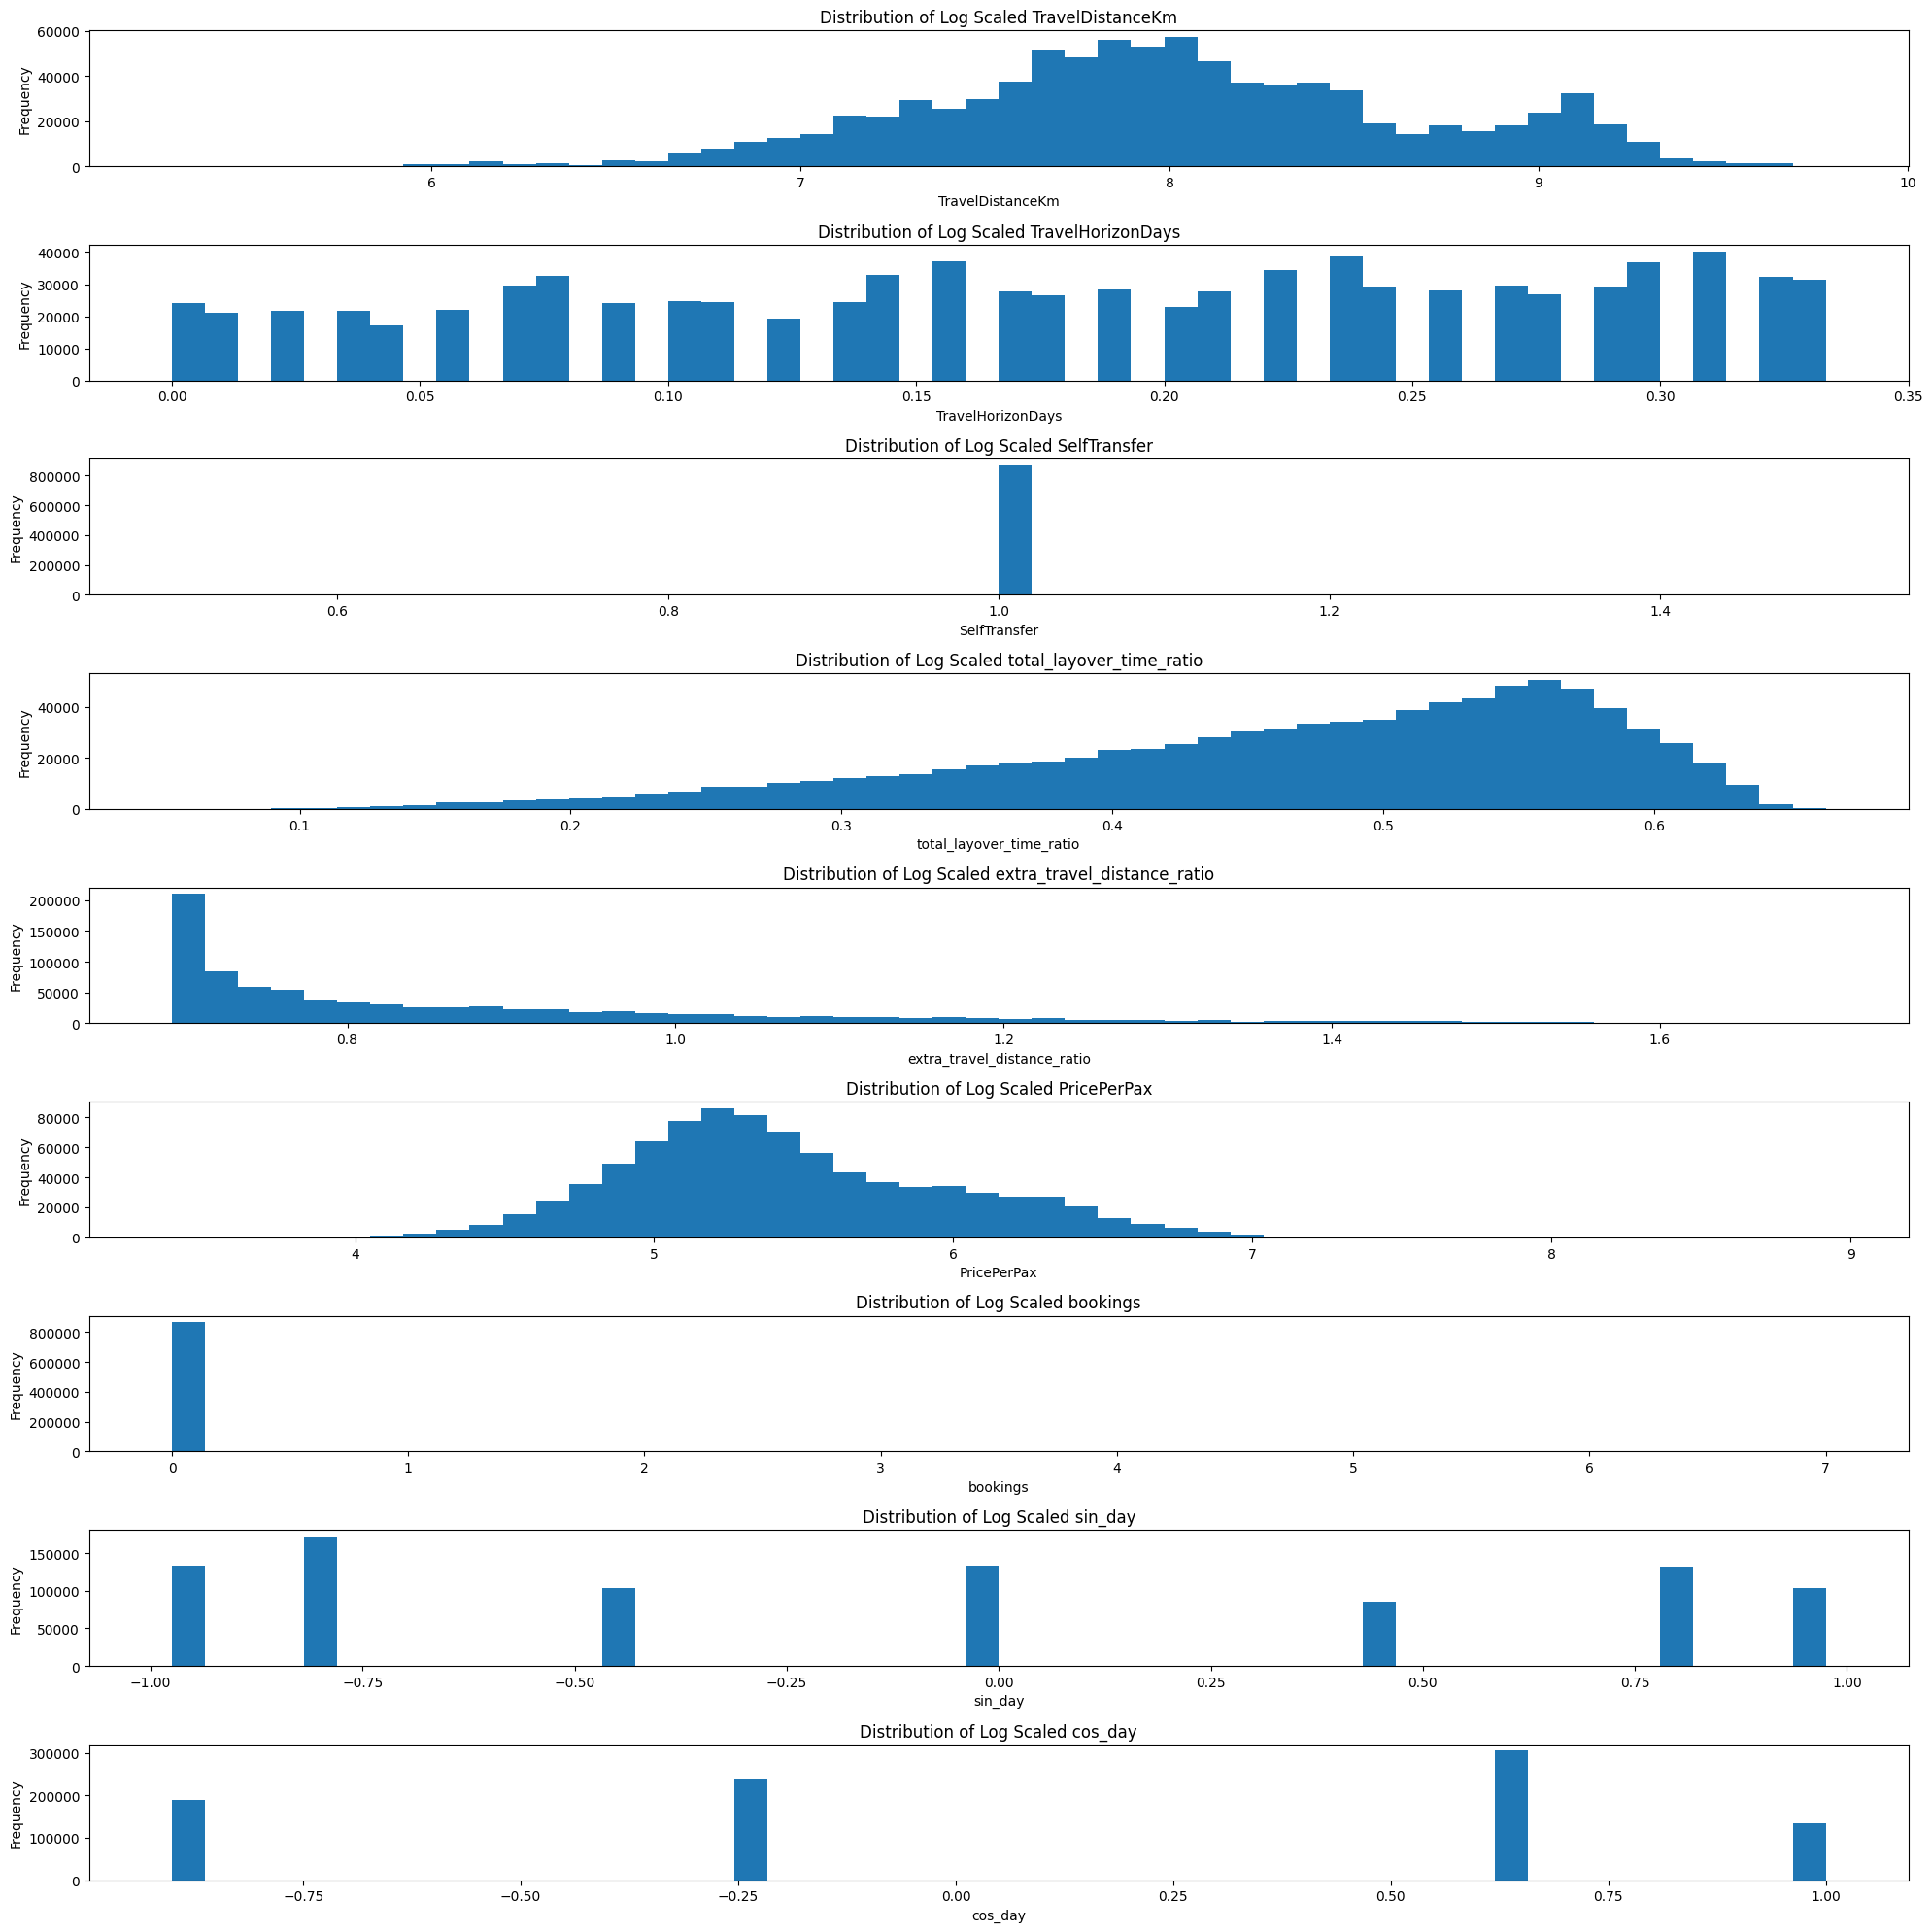

In [90]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(dohop_test.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of Log Scaled {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [91]:
# dohop_processing = dohop_test.copy()

In [92]:
bookings_column =   dohop_test["bookings"].copy()
dohop_test.drop(columns=["bookings"], inplace=True)


In [93]:
# dohop_test_array = scaler.transform(dohop_test)


In [94]:
# dohop_test = pd.DataFrame(dohop_test_array, columns=dohop_test.columns)


In [95]:
y_dohop_pred = model.predict(dohop_test)


27075/27075 [==============================] - 73s 3ms/step


In [96]:
dohop_test["bookings"] = bookings_column


In [97]:
dohop_test["Predicted_Score"] = y_dohop_pred.flatten()


In [98]:
dohop_test.head()

,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,sin_day,cos_day,bookings,Predicted_Score
0,7.447378,0.033333,1,0.413562,1.049008,4.660297,9.749279e-01,-0.222521,7.0,-0.424533
1,8.011932,0.133333,1,0.220788,0.701185,5.161504,-4.338837e-01,-0.900969,4.0,-0.542823
2,7.010356,0.033333,1,0.463573,0.787434,4.734120,9.749279e-01,-0.222521,4.0,-0.453152
3,7.843933,0.077778,1,0.302281,0.745004,5.078461,-7.818315e-01,0.623490,4.0,-0.570976
4,7.975207,0.166667,1,0.297534,0.742653,4.944015,-2.449294e-16,1.000000,3.0,-0.531578


In [99]:
# sampled_data = dohop_test.sample(frac=0.001)
# sampled_data.describe()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


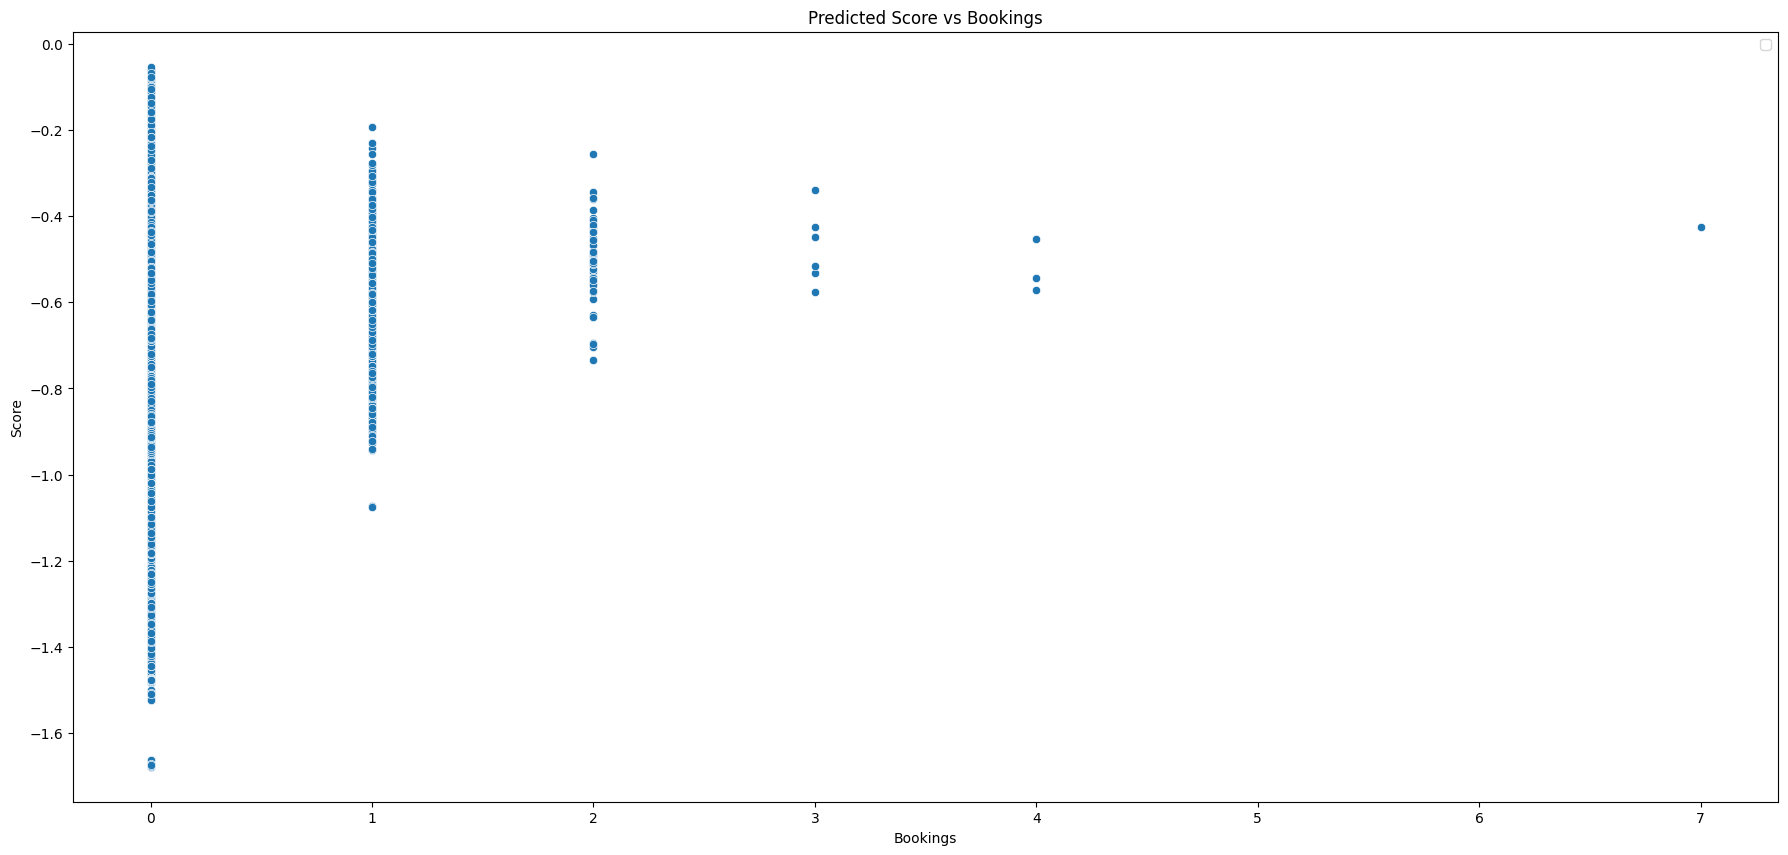

In [100]:
plt.figure(figsize = (22, 10))
sns.scatterplot(data=dohop_test, y=dohop_test["Predicted_Score"], x=dohop_test["bookings"])
plt.xlabel("Bookings")
plt.ylabel("Score")
plt.legend(loc='upper right')
plt.title("Predicted Score vs Bookings")
plt.show()


In [101]:
# savings = dohop_test[dohop_test["Predicted_Score"] < 2.35]
# savings.count() / dohop_test.count()


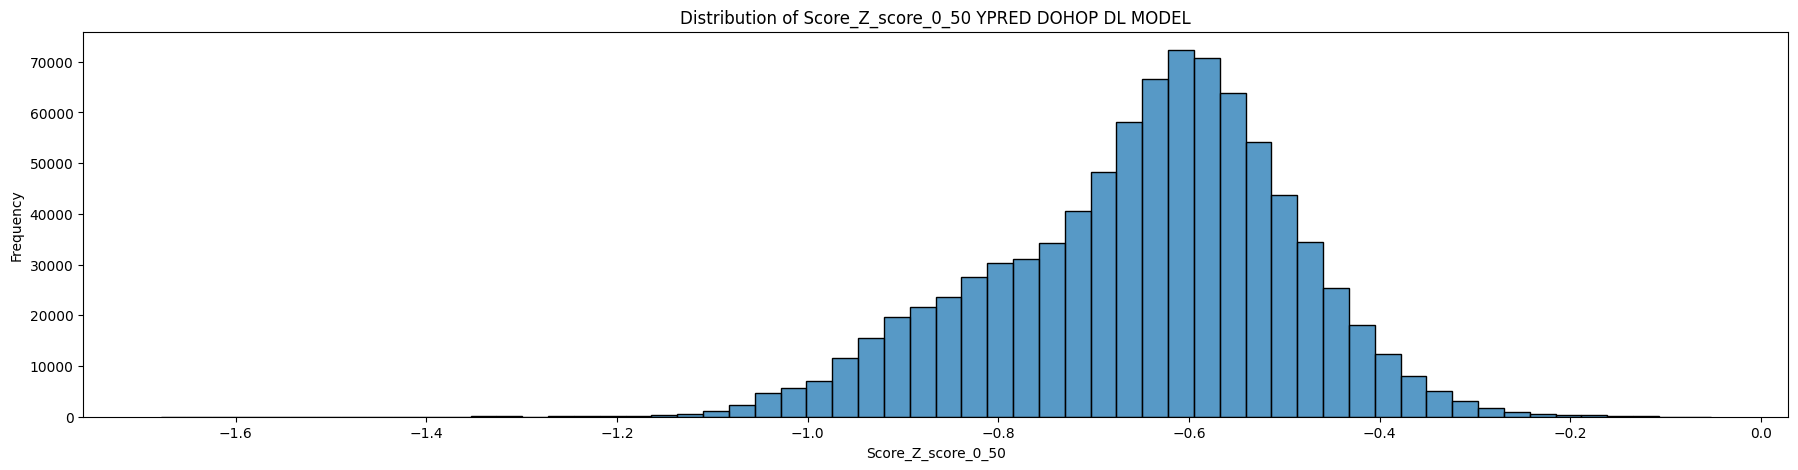

In [102]:
plt.figure(figsize = (22, 5))
sns.histplot(y_dohop_pred.flatten(), bins=60)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50 YPRED DOHOP DL MODEL")
plt.show()


## Classification Results of DL model

In [103]:
results = classification_evaluation(dohop_test, model)

InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/agdoko/.pyenv/versions/3.11.2/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/agdoko/.pyenv/versions/3.11.2/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/agdoko/.pyenv/versions/3.11.2/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/var/folders/gn/wfrvz0691n11n_vt3c8dm4sr0000gn/T/ipykernel_31276/542751784.py", line 1, in <module>

  File "/Users/agdoko/code/LaGenace/OptiFlyAi/Notebooks/../utils.py", line 672, in classification_evaluation

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [32,9], In[1]: [8,64]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_217059]

In [ ]:
results

{'min_threshold': 2.372377,
 'total_rows': 866374,
 'TP': 1000,
 'FP': 860863,
 'TN': 4511,
 'FN': 0}

In [ ]:
print(f"True Positive / Total is {results['TP']} / {results['total_rows']}")

NameError: name 'results' is not defined

## Building Baseline Poisson Regressor Model

In [ ]:
baseline = linear_model.PoissonRegressor()

In [ ]:
baseline.fit(X_train, y_train)

PoissonRegressor()

In [ ]:
d2_score_baseline = baseline.score(X_test, y_test)
print(f"The D2 (generalised R2) score is: {d2_score_baseline}")

The D2 (generalised R2) score is: 0.006701912595007742


## Classification Results of Baseline Model

In [ ]:
results_baseline = classification_evaluation(dohop_processing, baseline, scaler)

NameError: name 'dohop_processing' is not defined

In [ ]:
results_baseline

{'min_threshold': 2.721313742423088,
 'total_rows': 866374,
 'TP': 1000,
 'FP': 863478,
 'TN': 1896,
 'FN': 0}

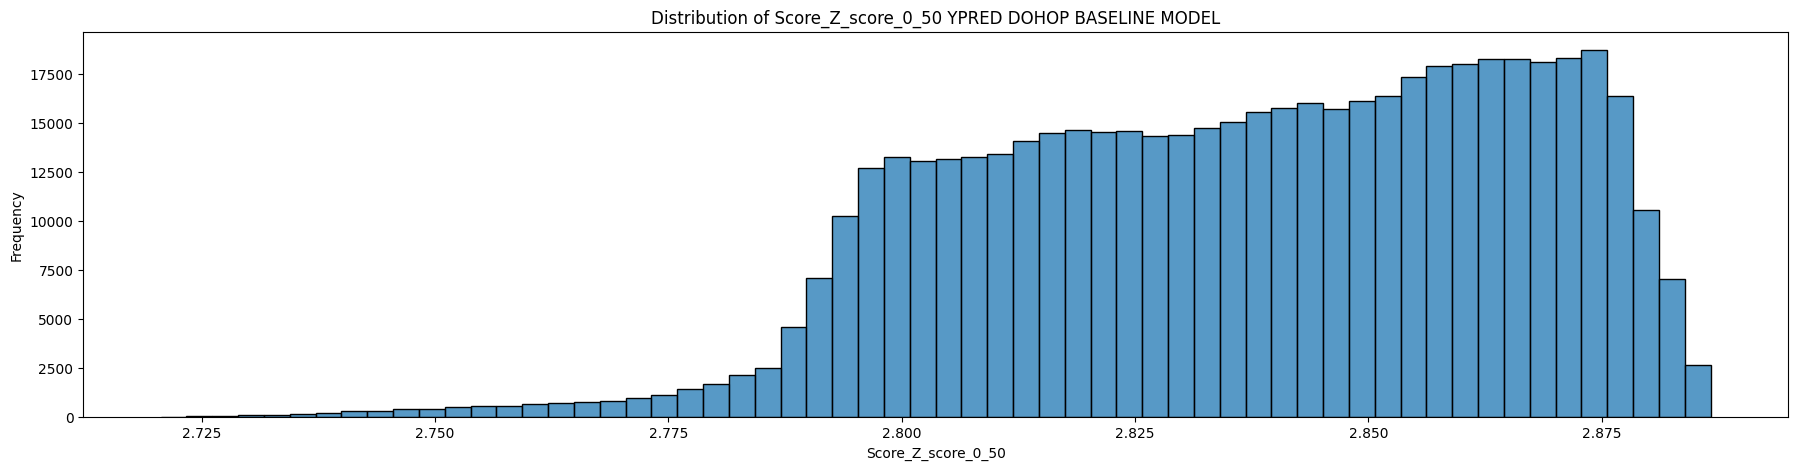

In [ ]:
plt.figure(figsize = (22, 5))
sns.histplot(baseline.predict(X_test).flatten(), bins=60)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50 YPRED DOHOP BASELINE MODEL")
plt.show()